In [2]:
# !git clone 'https://github.com/Lorenz92/SKADC1.git'
# % cd SKADC1
# !echo $PWD

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import sys
from astropy.io import fits
import os
import statistics

import src.dataset as dataset
import src.config as config 
from src.utils import *
import src.preprocessing as prep
import src.models as models
import src.losses as loss

from keras import backend as K

path = config.TRAIN_PATCHES_FOLDER
%load_ext autoreload
%autoreload 2

np.random.seed(config.RANDOM_SEED)

In [ ]:
use_colab = True

if use_colab:
    # Read file from Colab Notebook
    from google.colab import drive
    drive.mount('/content/drive')
    MODEL_WEIGHTS = "drive/My Drive/Colab Notebooks/"

In [3]:
# Dataset parsing and loading
# use "subset" in config file to load a small portion of data for development/debugging purposes
ska_dataset = dataset.SKADataset()
ska_dataset.load_dataset()

Dataset shape: (19222, 15)


,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,PA,SIZE,CLASS,SELECTION,x,y
0,24121695,-0.642227,-29.775242,-0.642316,-29.775211,0.000035,0.000000,5.600,5.551,328.554,1,1,1,19704.519,17712.942
1,20167150,-0.390473,-29.867493,-0.390667,-29.868851,0.029555,0.016924,107.110,43.263,191.258,1,1,1,18401.338,17160.919
2,20045120,-0.021411,-29.643486,-0.021359,-29.643561,0.000653,0.012185,5.037,3.525,276.587,1,1,1,16493.600,18506.577
3,33938384,-0.316375,-29.697647,-0.316375,-29.697647,0.000017,0.000000,0.847,0.266,346.641,2,1,1,18020.319,18182.095
4,7527248,-0.336528,-29.627335,-0.336527,-29.627338,0.000054,0.044763,3.343,1.515,279.006,1,1,1,18125.824,18600.680


In [5]:
ska_dataset.load_train_image()

Loading FITS file /Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/data/training/560Mhz_1000h.fits


### Preprocessing

In [6]:
ska_dataset.process_dataset()
#coords = ska_dataset._convert_boxes_to_px_coord(ska_dataset.raw_train_df, data_560Mhz_1000h_fits[0].header )

100%|██████████| 19222/19222 [00:02<00:00, 6833.39it/s]
Initial dataset shape: (19222, 15)
Found 0 boxes with zero area
Rows to be deleted: 0
New dataset shape: (19222, 15)
Extending dataset with new computed columns...
Final cleaned dataset shape: (19222, 26)

Enlarging bboxes...
DONE - Enlarging bboxes...


### Prima

In [7]:
df_train = ska_dataset.cleaned_train_df
df_train.shape
df_train.head()

,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,PA,...,y1,x2,y2,major_semia_px,minor_semia_px,pa_in_rad,width,height,area_orig,area_cropped
0,24121695.0,-0.642227,-29.775242,-0.642316,-29.775211,0.000035,0.000000,5.600,5.551,328.554,...,17706.708393,19710.764566,17719.170105,6.264429,6.218255,5.734349,12.503792,12.461712,155.818657,155.818657
1,20167150.0,-0.390473,-29.867493,-0.390667,-29.868851,0.029555,0.016924,107.110,43.263,191.258,...,17112.270219,18509.603417,17209.564571,110.037236,44.503323,3.338082,216.538139,97.294352,21067.937901,21067.937901
2,20045120.0,-0.021411,-29.643486,-0.021359,-29.643561,0.000653,0.012185,5.037,3.525,276.587,...,18500.850356,16498.009965,18512.295208,5.738106,4.389739,4.827354,8.820318,11.444852,100.947234,100.947234
3,33938384.0,-0.316375,-29.697647,-0.316375,-29.697647,0.000017,0.000000,0.847,0.266,346.641,...,18179.521298,18023.322729,18184.661968,3.031418,2.541842,6.050027,6.014593,5.140670,30.919039,30.919039
4,7527248.0,-0.336528,-29.627335,-0.336527,-29.627338,0.000054,0.044763,3.343,1.515,279.006,...,18596.465498,18128.789688,18604.884928,4.236891,2.929772,4.869573,5.937378,8.419429,49.989332,49.989332


### Dopo

In [8]:
df_train = ska_dataset.cleaned_train_df
df_train.shape
df_train.head()

,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,PA,...,y1,x2,y2,major_semia_px,minor_semia_px,pa_in_rad,width,height,area_orig,area_cropped
0,24121695.0,-0.642227,-29.775242,-0.642316,-29.775211,0.000035,0.000000,5.600,5.551,328.554,...,17706.708393,19710.764566,17719.170105,6.264429,6.218255,5.734349,12.503792,12.461712,155.818657,155.818657
1,20167150.0,-0.390473,-29.867493,-0.390667,-29.868851,0.029555,0.016924,107.110,43.263,191.258,...,17112.270219,18509.603417,17209.564571,110.037236,44.503323,3.338082,216.538139,97.294352,21067.937901,21067.937901
2,20045120.0,-0.021411,-29.643486,-0.021359,-29.643561,0.000653,0.012185,5.037,3.525,276.587,...,18500.850356,16498.009965,18512.295208,5.738106,4.389739,4.827354,8.820318,11.444852,100.947234,100.947234
3,33938384.0,-0.316375,-29.697647,-0.316375,-29.697647,0.000017,0.000000,0.847,0.266,346.641,...,18179.521298,18023.322729,18184.661968,3.031418,2.541842,6.050027,6.014593,5.140670,30.919039,30.919039
4,7527248.0,-0.336528,-29.627335,-0.336527,-29.627338,0.000054,0.044763,3.343,1.515,279.006,...,18596.465498,18128.789688,18604.884928,4.236891,2.929772,4.869573,5.937378,8.419429,49.989332,49.989332


In [9]:
df_train[['width', 'height', 'area_orig', 'area_cropped']].describe()

,width,height,area_orig,area_cropped
count,19222.000000,19222.000000,19222.000000,19222.000000
mean,6.282190,6.285123,44.731314,44.731314
std,3.122242,2.910949,169.529219,169.529219
min,4.964839,4.964839,24.649628,24.649628
25%,5.114121,5.116855,26.770928,26.770928
50%,5.388071,5.394034,29.928541,29.928541
75%,6.193903,6.206960,39.145862,39.145862
max,216.538139,97.294352,21067.937901,21067.937901


min val = -1.9004023e-06
max val = 0.006585681
4.561610766868865e-14 4.5037468510513567e-07
lower threshold 1.1259367127628392e-06
min magnitude -6
max magnitude -2


(3191, 3498)

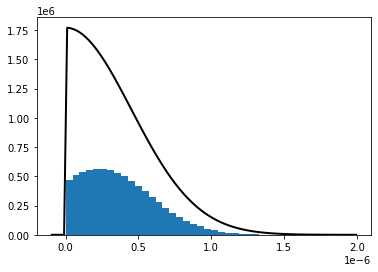

In [10]:
plot_Noise_Hist = False
ska_dataset.cut_preprocess_image(plot_Noise_Hist)
ska_dataset.data_560Mhz_1000h_train.shape


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]image saved
max gray level val =  176.0


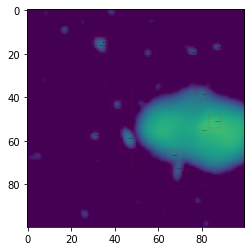



  1%|▏         | 1/70 [00:02<03:18,  2.87s/it]image saved
max gray level val =  176.0


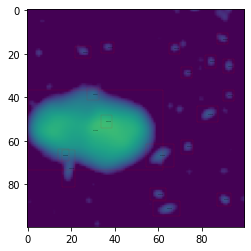



  3%|▎         | 2/70 [00:05<03:18,  2.92s/it]image saved
max gray level val =  154.0


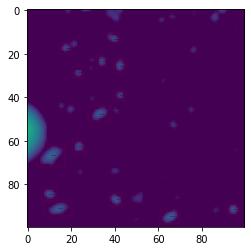



100%|██████████| 70/70 [00:08<00:00,  8.03it/s]

  2%|▏         | 1/64 [00:08<09:09,  8.72s/it]

  0%|          | 0/70 [00:00<?, ?it/s]image saved
max gray level val =  176.0


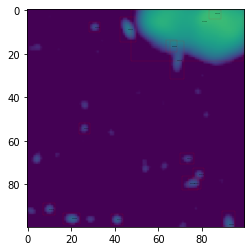



  1%|▏         | 1/70 [00:03<03:46,  3.28s/it]image saved
max gray level val =  176.0


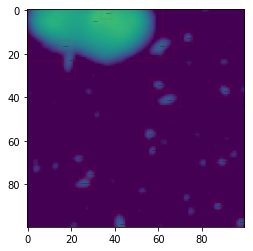



  3%|▎         | 2/70 [00:06<03:27,  3.05s/it]image saved
max gray level val =  154.0


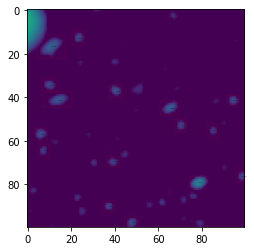



100%|██████████| 70/70 [00:08<00:00,  7.82it/s]

  3%|▎         | 2/64 [00:17<09:09,  8.87s/it]

  0%|          | 0/70 [00:00<?, ?it/s]image saved
max gray level val =  85.0


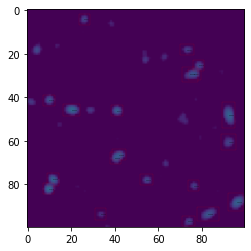



  1%|▏         | 1/70 [00:03<03:52,  3.37s/it]image saved
max gray level val =  95.0


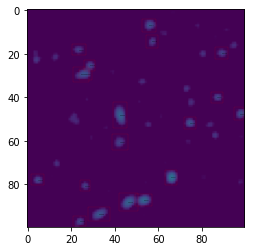



  3%|▎         | 2/70 [00:06<03:40,  3.24s/it]image saved
max gray level val =  114.0


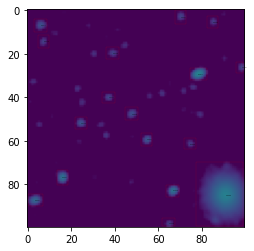



100%|██████████| 70/70 [00:09<00:00,  7.40it/s]

  5%|▍         | 3/64 [00:27<09:17,  9.14s/it]

  0%|          | 0/70 [00:00<?, ?it/s]image saved
max gray level val =  85.0


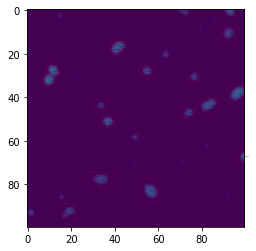



  1%|▏         | 1/70 [00:03<03:38,  3.17s/it]image saved
max gray level val =  108.0


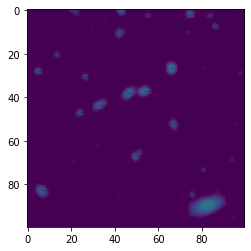



  3%|▎         | 2/70 [00:06<03:26,  3.04s/it]image saved
max gray level val =  110.0


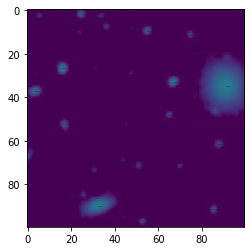



100%|██████████| 70/70 [00:08<00:00,  7.80it/s]

  6%|▋         | 4/64 [00:36<09:04,  9.08s/it]

  0%|          | 0/70 [00:00<?, ?it/s]image saved
max gray level val =  115.0


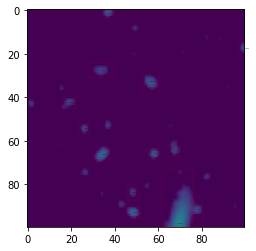



  1%|▏         | 1/70 [00:03<03:49,  3.33s/it]image saved
max gray level val =  119.0


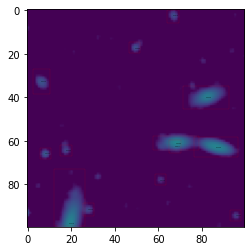



  3%|▎         | 2/70 [00:06<03:49,  3.37s/it]image saved
max gray level val =  119.0


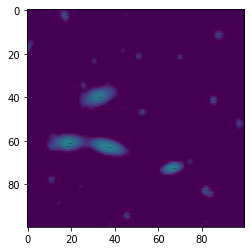



100%|██████████| 70/70 [00:09<00:00,  7.24it/s]

  8%|▊         | 5/64 [00:45<09:08,  9.29s/it]

  0%|          | 0/70 [00:00<?, ?it/s]image saved
max gray level val =  115.0


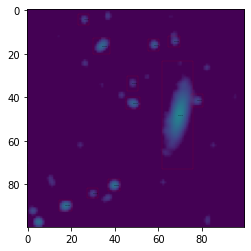



  1%|▏         | 1/70 [00:03<03:47,  3.29s/it]image saved
max gray level val =  119.0


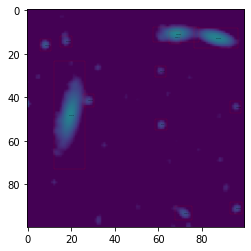



  3%|▎         | 2/70 [00:06<03:32,  3.13s/it]image saved
max gray level val =  119.0


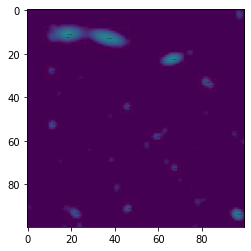



100%|██████████| 70/70 [00:09<00:00,  7.51it/s]

  9%|▉         | 6/64 [00:55<08:59,  9.31s/it]

  0%|          | 0/70 [00:00<?, ?it/s]image saved
max gray level val =  110.0


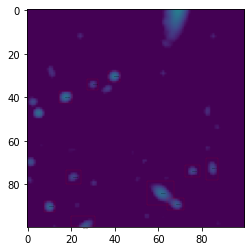



  1%|▏         | 1/70 [00:03<03:28,  3.02s/it]image saved
max gray level val =  110.0


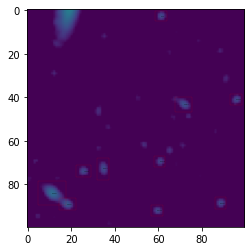



  3%|▎         | 2/70 [00:06<03:31,  3.11s/it]image saved
max gray level val =  104.0


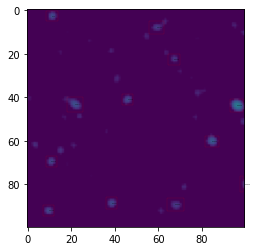



100%|██████████| 70/70 [00:10<00:00,  6.97it/s]

 11%|█         | 7/64 [01:05<09:04,  9.55s/it]

  0%|          | 0/70 [00:00<?, ?it/s]image saved
max gray level val =  132.0


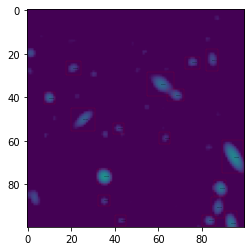



  1%|▏         | 1/70 [00:03<03:56,  3.43s/it]image saved
max gray level val =  117.0


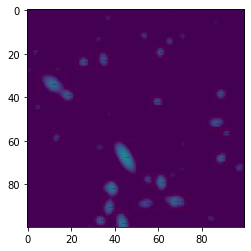



  3%|▎         | 2/70 [00:06<03:40,  3.24s/it]image saved
max gray level val =  88.0


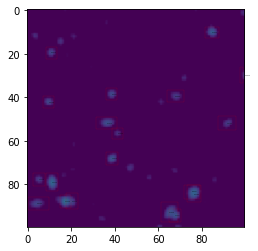



100%|██████████| 70/70 [00:09<00:00,  7.33it/s]

 12%|█▎        | 8/64 [01:14<08:55,  9.55s/it]

  0%|          | 0/70 [00:00<?, ?it/s]image saved
max gray level val =  132.0


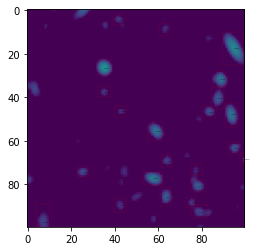



  1%|▏         | 1/70 [00:03<03:57,  3.44s/it]image saved
max gray level val =  117.0


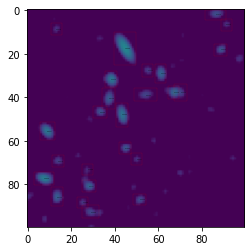



  3%|▎         | 2/70 [00:07<04:13,  3.73s/it]image saved
max gray level val =  117.0


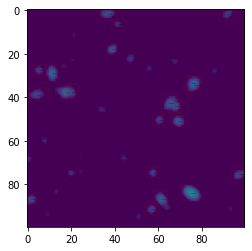



100%|██████████| 70/70 [00:10<00:00,  6.40it/s]

 14%|█▍        | 9/64 [01:25<09:09,  9.99s/it]

  0%|          | 0/70 [00:00<?, ?it/s]image saved
max gray level val =  129.0


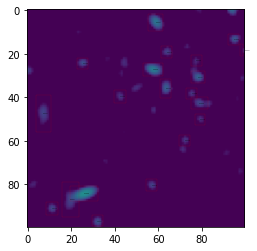



  1%|▏         | 1/70 [00:04<05:09,  4.49s/it]image saved
max gray level val =  106.0


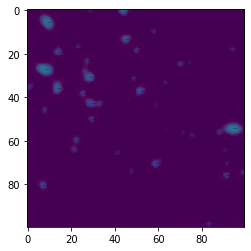



  3%|▎         | 2/70 [00:12<07:39,  6.75s/it]image saved
max gray level val =  117.0


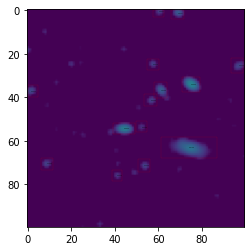



100%|██████████| 70/70 [00:18<00:00,  3.76it/s]

 16%|█▌        | 10/64 [01:44<11:23, 12.66s/it]

  0%|          | 0/70 [00:00<?, ?it/s]image saved
max gray level val =  147.0


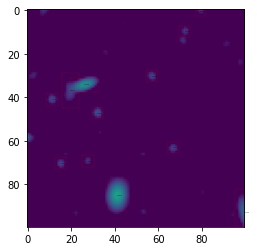



  1%|▏         | 1/70 [00:05<06:35,  5.73s/it]image saved
max gray level val =  137.0


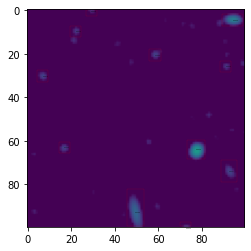



  3%|▎         | 2/70 [00:10<05:46,  5.10s/it]image saved
max gray level val =  137.0


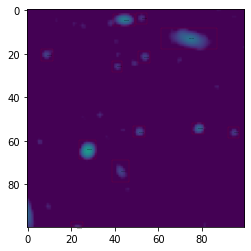



100%|██████████| 70/70 [00:14<00:00,  4.69it/s]

 17%|█▋        | 11/64 [01:59<11:47, 13.36s/it]

  0%|          | 0/70 [00:00<?, ?it/s]image saved
max gray level val =  147.0


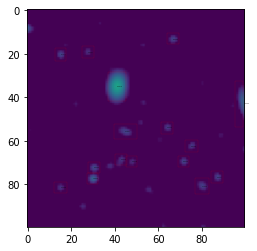



  1%|▏         | 1/70 [00:05<06:51,  5.97s/it]image saved
max gray level val =  137.0


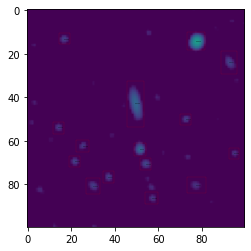



  3%|▎         | 2/70 [00:10<05:55,  5.23s/it]image saved
max gray level val =  137.0


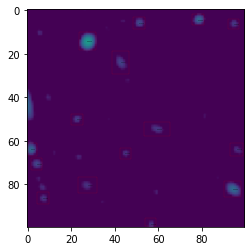



100%|██████████| 70/70 [00:16<00:00,  4.34it/s]

 19%|█▉        | 12/64 [02:15<12:18, 14.21s/it]

  0%|          | 0/70 [00:00<?, ?it/s]image saved
max gray level val =  76.0


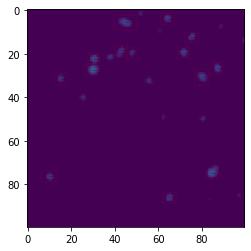



  1%|▏         | 1/70 [00:06<07:31,  6.55s/it]image saved
max gray level val =  85.0


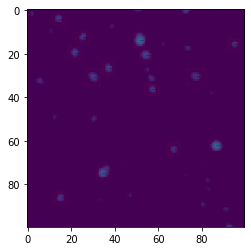



  3%|▎         | 2/70 [00:12<06:42,  5.92s/it]image saved
max gray level val =  94.0


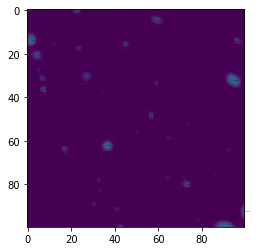



100%|██████████| 70/70 [00:16<00:00,  4.15it/s]

 20%|██        | 13/64 [02:32<12:45, 15.02s/it]

  0%|          | 0/70 [00:00<?, ?it/s]image saved
max gray level val =  68.0


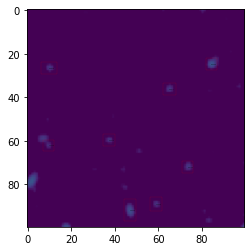



  1%|▏         | 1/70 [00:06<07:41,  6.68s/it]image saved
max gray level val =  85.0


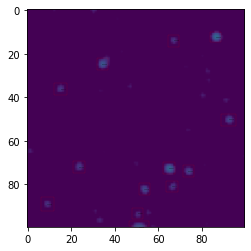



  3%|▎         | 2/70 [00:11<06:20,  5.60s/it]image saved
max gray level val =  95.0


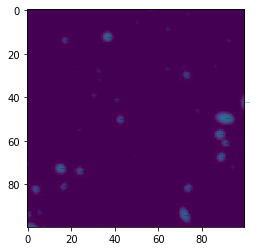



100%|██████████| 70/70 [00:16<00:00,  4.22it/s]

 22%|██▏       | 14/64 [02:48<12:54, 15.50s/it]

  0%|          | 0/70 [00:00<?, ?it/s]image saved
max gray level val =  94.0


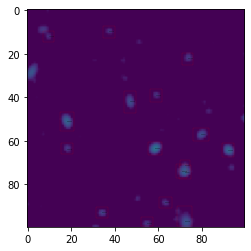



  1%|▏         | 1/70 [00:06<07:41,  6.69s/it]image saved
max gray level val =  99.0


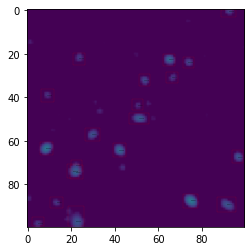



  3%|▎         | 2/70 [00:11<06:12,  5.47s/it]image saved
max gray level val =  99.0


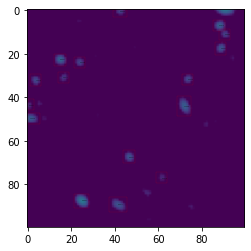



100%|██████████| 70/70 [00:16<00:00,  4.23it/s]

 23%|██▎       | 15/64 [03:05<12:55, 15.82s/it]

  0%|          | 0/70 [00:00<?, ?it/s]image saved
max gray level val =  103.0


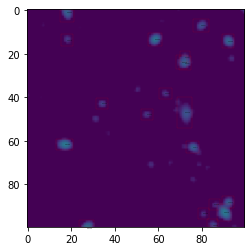



  1%|▏         | 1/70 [00:06<08:02,  7.00s/it]image saved
max gray level val =  103.0


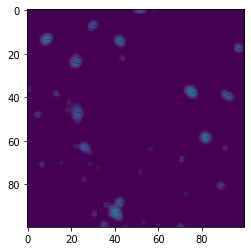



  3%|▎         | 2/70 [00:11<06:35,  5.82s/it]image saved
max gray level val =  99.0


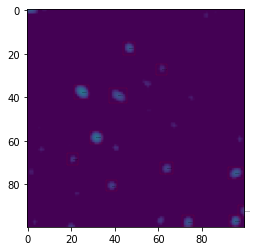



100%|██████████| 70/70 [00:16<00:00,  4.14it/s]

 25%|██▌       | 16/64 [03:22<12:55, 16.15s/it]

  0%|          | 0/70 [00:00<?, ?it/s]image saved
max gray level val =  103.0


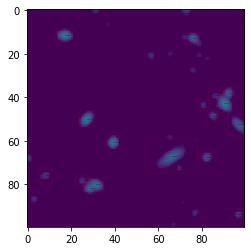



  1%|▏         | 1/70 [00:05<06:37,  5.76s/it]image saved
max gray level val =  103.0


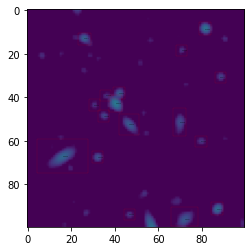



  3%|▎         | 2/70 [00:10<05:37,  4.97s/it]image saved
max gray level val =  93.0


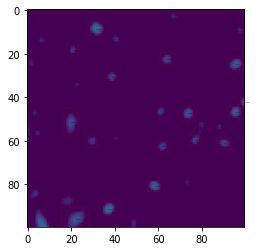



100%|██████████| 70/70 [00:14<00:00,  4.75it/s]

 27%|██▋       | 17/64 [03:37<12:19, 15.73s/it]

  0%|          | 0/70 [00:00<?, ?it/s]image saved
max gray level val =  101.0


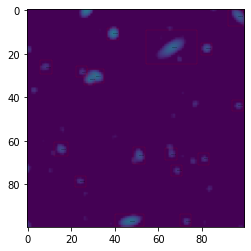



  1%|▏         | 1/70 [00:05<06:45,  5.87s/it]image saved
max gray level val =  101.0


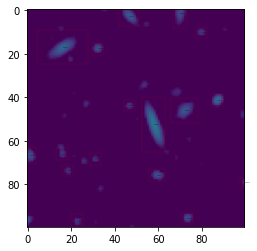



  3%|▎         | 2/70 [00:10<05:59,  5.29s/it]image saved
max gray level val =  101.0


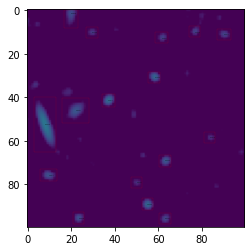



100%|██████████| 70/70 [00:18<00:00,  3.84it/s]

 28%|██▊       | 18/64 [03:55<12:38, 16.49s/it]

  0%|          | 0/70 [00:00<?, ?it/s]image saved
max gray level val =  93.0


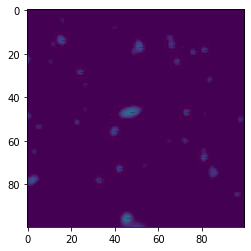



  1%|▏         | 1/70 [00:07<08:18,  7.23s/it]image saved
max gray level val =  103.0


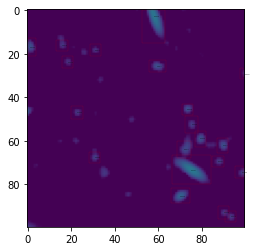



  3%|▎         | 2/70 [00:13<07:13,  6.38s/it]image saved
max gray level val =  103.0


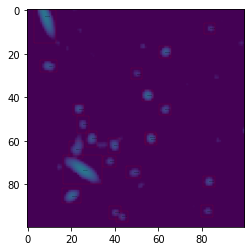



100%|██████████| 70/70 [00:18<00:00,  3.71it/s]

 30%|██▉       | 19/64 [04:14<12:54, 17.21s/it]

  0%|          | 0/70 [00:00<?, ?it/s]image saved
max gray level val =  127.0


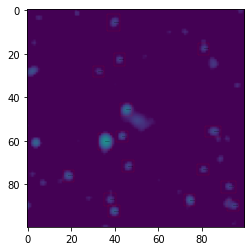



  1%|▏         | 1/70 [00:06<07:26,  6.48s/it]image saved
max gray level val =  103.0


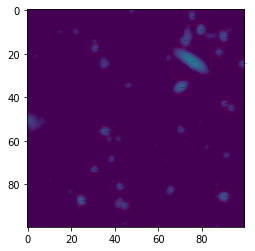



  3%|▎         | 2/70 [00:11<06:35,  5.82s/it]image saved
max gray level val =  103.0


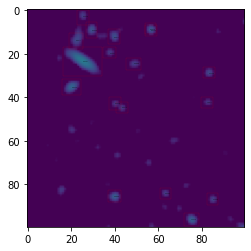



100%|██████████| 70/70 [00:17<00:00,  4.02it/s]

 31%|███▏      | 20/64 [04:31<12:39, 17.27s/it]

  0%|          | 0/70 [00:00<?, ?it/s]image saved
max gray level val =  127.0


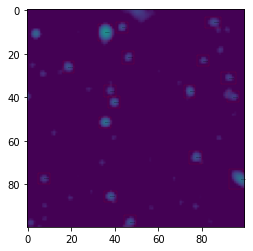



  1%|▏         | 1/70 [00:07<08:25,  7.33s/it]image saved
max gray level val =  93.0


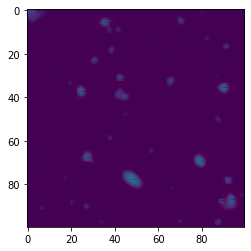



  3%|▎         | 2/70 [00:13<07:24,  6.54s/it]image saved
max gray level val =  89.0


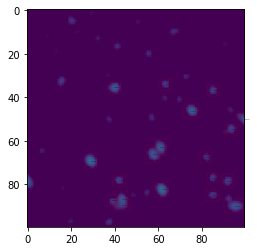



100%|██████████| 70/70 [00:19<00:00,  3.63it/s]

100%|██████████| 64/64 [04:51<00:00,  4.55s/it]['1_1' '2_1' '3_1']
3



In [80]:
show_plot=True
ska_dataset.generate_patches(show_plot) # Remember to remove internal return

number of possible class combinations: 7


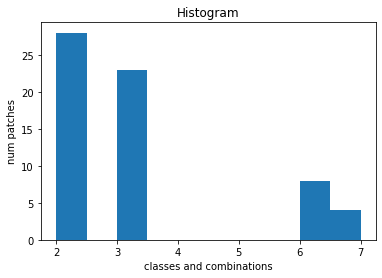

In [81]:
ska_dataset.analyze_class_distribution()

In [13]:
# class_list = ['class1','class2','class3']
# d2 = {i:0 for i in class_list}
# d2

In [14]:
# d2['class1']=1
# d2

In [15]:
# dic={
#     'class1':1
#     ,'class2':1
#     ,'class3':0
# }

In [16]:
# a = [i for i in dic.values()]
# a

In [17]:
# dic['nuovaclasse']=5

In [82]:
ska_dataset.split_train_val(random_state=42, val_portion=0)

print(len(ska_dataset.train_patch_list))
print(len(ska_dataset.val_patch_list))


key_1 not splitted
key_2 not splitted
key_3 not splitted
key_4 not splitted
key_5 not splitted
key_6 not splitted
key_7 not splitted
split ended
63
0


## datagen + calc_rpn -> rpn_net -> rpn_to_roi -> calc_iou -> cls_net

# Training

### Get FRCNN model

In [ ]:
# Choose the feature extraction model

backbone='vgg16'


In [199]:
input_shape_1=(config.resizeFinalDim, config.resizeFinalDim,1)
input_shape_2=(None, 4)

rpn_model, detector_model, total_model = models.get_train_model(input_shape_1=input_shape_1, input_shape_2=input_shape_2, anchor_num=config.anchor_num, pooling_regions=config.pooling_regions, num_rois=config.num_rois, num_classes=len(ska_dataset.class_list)+1, backbone=backbone, use_expander=False)

rpn_model.summary()
detector_model.summary()
total_model.summary()

Model: "RegionProposal"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 600, 600, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 600, 600, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 600, 600, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 300, 300, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 300, 300, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 300, 300, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 150, 150, 128)  

### Load weights

In [200]:
models.load_weigths(rpn_model, detector_model, backbone, resume_train=True)
models.compile_models(rpn_model, detector_model, total_model, rpn_losses=[loss.rpn_loss_cls, loss.rpn_loss_regr], detector_losses=[loss.detector_loss_cls, loss.detector_loss_regr], class_list=ska_dataset.class_list)

In [25]:
# Specifically checking backbone weights

# total_model.weights[24:25][0][0][0][0]

In [274]:
# Check that all of the pretrained weights have been loaded.
import numpy as np
for i, j in zip(total_model.weights, rpn_model.weights): 
    # print(i,j)
    assert np.allclose(i,j), 'Weights don\'t match!'

### Train

In [275]:
from src.train import *
val_patch_list = None
train_frcnn(rpn_model, detector_model, total_model, ska_dataset.train_patch_list, ska_dataset.val_patch_list, ska_dataset.class_list, num_epochs=30, patches_folder_path=config.TRAIN_PATCHES_FOLDER, backbone='vgg16', resume_train=True)

Error: Pip module Unable to parse debugpy output, please log an issue with https://github.com/microsoft/vscode-jupyter is required for debugging cells. You will need to install it to debug cells.

# Validation

In [257]:
input_shape_1=(config.resizeFinalDim, config.resizeFinalDim,1)
input_shape_2=(None, 4)

rpn_model_eval, detector_model_eval, total_model_eval = models.get_eval_model(input_shape_1=input_shape_1, input_shape_2=input_shape_2, input_shape_fmap=None, anchor_num=config.anchor_num, pooling_regions=config.pooling_regions, num_rois=config.num_rois, num_classes=len(ska_dataset.class_list)+1, backbone=backbone, use_expander=False)

rpn_model_eval.summary()
detector_model_eval.summary()
total_model_eval.summary()

Model: "RegionProposal"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 600, 600, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 600, 600, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 600, 600, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 300, 300, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 300, 300, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 300, 300, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 150, 150, 128)  

In [258]:
# Models used for mAP eval
models.load_weigths(rpn_model_eval, detector_model_eval, backbone)
models.compile_models(rpn_model_eval, detector_model_eval, total_model_eval, rpn_losses=[loss.rpn_loss_cls, loss.rpn_loss_regr], detector_losses=[loss.detector_loss_cls, loss.detector_loss_regr], class_list=ska_dataset.class_list)

In [259]:
import time
from tqdm import tqdm

def get_real_coordinates(x1, y1, x2, y2):
    ratio = config.resizeFinalDim / config.patch_dim
    real_x1 = int(round(x1 // ratio))
    real_y1 = int(round(y1 // ratio))
    real_x2 = int(round(x2 // ratio))
    real_y2 = int(round(y2 // ratio))

    return (real_x1, real_y1, real_x2 ,real_y2)

def generate_output(img_name, bboxes, probs, plot=False):
    all_dets = []
    [img_name] = img_name
    boxes_coords ={'x1s':[], 'y1s':[], 'x2s':[], 'y2s':[], 'class':[], 'prob':[]}
    
    for key in bboxes:
        bbox = np.array(bboxes[key])

        new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.5)
       
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk,:]
            print((x1, y1, x2, y2))
            (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(x1, y1, x2, y2)

            boxes_coords['x1s'].append(real_x1)
            boxes_coords['y1s'].append(real_y1)
            boxes_coords['x2s'].append(real_x2)
            boxes_coords['y2s'].append(real_y2)
            boxes_coords['class'].append(key)
            boxes_coords['prob'].append(new_probs[jk])

    a = pd.DataFrame.from_dict(boxes_coords)
    display(a.head())
    a.to_pickle(f'{config.VAL_PATCHES_FOLDER}/{img_name}/{img_name}.pkl')

    return boxes_coords

def predict(image, class_list, acceptance_treshold):
    start = time.time()

    print('Predict')

    # get the feature maps and output from the RPN
    [Y1, Y2, F] = rpn_model_eval.predict_on_batch(image)
    # [Y1, Y2] = rpn_model.predict_on_batch(image)

    print('rpn_to_roi')

    # print(Y1.shape, Y2.shape)

    R = rpn_to_roi(Y1, Y2, overlap_thresh=0.5, max_boxes=2000)

    # convert from (x1,y1,x2,y2) to (x,y,w,h)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]

    bboxes = {}
    probs = {}

    for jk in range(R.shape[0] // C.num_rois + 1):
        ROIs = np.expand_dims(R[C.num_rois * jk:C.num_rois * (jk + 1), :], axis=0)
        if ROIs.shape[1] == 0:
            break

        if jk == R.shape[0] // C.num_rois:
            # pad R
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0], C.num_rois, curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded

        # print(ROIs)

        [P_cls, P_regr] = detector_model_eval.predict([F, ROIs])
        # [P_cls, P_regr] = detector_model.predict([image, ROIs])
        # print(P_cls.shape)
        print(P_cls)
        for ii in range(P_cls.shape[1]):
            # if classification perc is too low OR it is. a 'bg' image THEN discard
            if np.max(P_cls[0,ii,:]) < acceptance_treshold or np.argmax(P_cls[0,ii,:]) == (P_cls.shape[2] - 1):
                continue

            cls_num = np.argmax(P_cls[0, ii, :])
            cls_name = class_mapping[cls_num]

            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []
            (x,y,w,h) = ROIs[0,ii,:]
            
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
                tx /= config.classifier_regr_std[0]
                ty /= config.classifier_regr_std[1]
                tw /= config.classifier_regr_std[2]
                th /= config.classifier_regr_std[3]
                
                X, T = np.zeros((4, 1, 1)), np.zeros((4, 1, 1))
                
                X[0,0,0] = x
                X[1,0,0] = y
                X[2,0,0] = w
                X[3,0,0] = h
                
                T[0,0,0] = tx
                T[1,0,0] = ty
                T[2,0,0] = tw
                T[3,0,0] = th
                
                [[[x_np]], [[y_np]], [[w_np]], [[h_np]]] = apply_regr_np(X, T)
            except:
                pass
            bboxes[cls_name].append([config.rpn_stride*x, config.rpn_stride*y, config.rpn_stride*(x+w), config.rpn_stride*(y+h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))
    
   
    print(f'Elapsed:{time.time()-start}')
    return bboxes, probs


['100_16476_16729_100']


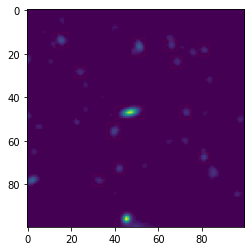

In [226]:
print(ska_dataset.train_patch_list[0:1])
print_img(config.TRAIN_PATCHES_FOLDER, ska_dataset.train_patch_list[19])


In [229]:
patch_id = ska_dataset.train_patch_list[49:50]
print(patch_id)

gt = pd.read_pickle(f'{config.TRAIN_PATCHES_FOLDER}/{patch_id[0]}/{patch_id[0]}.pkl')
display(gt['class_label'])


['26400_16426_17579_100']


0     3_1
1     2_1
2     2_1
3     2_1
4     2_1
5     2_1
6     3_1
7     2_1
8     2_1
9     2_1
10    2_1
11    2_1
12    2_1
13    2_1
14    2_1
15    2_1
16    2_1
Name: class_label, dtype: object

In [263]:
patch_id = ska_dataset.train_patch_list[49:50]
print(patch_id)
gt = pd.read_pickle(f'{config.TRAIN_PATCHES_FOLDER}/{patch_id[0]}/{patch_id[0]}.pkl')
display(gt['class_label'])

class_mapping = {key:value for key, value in enumerate(ska_dataset.class_list)}

eval_datagen = prep.get_anchor_gt(config.TRAIN_PATCHES_FOLDER, patch_id, mode='eval')
image, _, _, _, _ = next(eval_datagen)
# print(image)
bboxes, probs = predict(image, ska_dataset.class_list, acceptance_treshold=.4)
# print('-'*10)
print(bboxes)
print(probs)

['26400_16426_17579_100']


0     3_1
1     2_1
2     2_1
3     2_1
4     2_1
5     2_1
6     3_1
7     2_1
8     2_1
9     2_1
10    2_1
11    2_1
12    2_1
13    2_1
14    2_1
15    2_1
16    2_1
Name: class_label, dtype: object

0.47883904 0.00090118 0.51935863]
  [0.00090118 0.47883904 0.00090118 0.51935863]
  [0.00090118 0.47883904 0.00090118 0.51935863]
  [0.00090118 0.47883904 0.00090118 0.51935863]]]
[[[0.00090118 0.47883904 0.00090118 0.51935863]
  [0.00090118 0.47883904 0.00090118 0.51935863]
  [0.00090118 0.47883904 0.00090118 0.51935863]
  [0.00090118 0.47883904 0.00090118 0.51935863]]]
[[[0.00090118 0.47883904 0.00090118 0.51935863]
  [0.00090118 0.47883904 0.00090118 0.51935863]
  [0.00090118 0.47883904 0.00090118 0.51935863]
  [0.00090118 0.47883904 0.00090118 0.51935863]]]
[[[0.00090118 0.47883904 0.00090118 0.51935863]
  [0.00090118 0.47883904 0.00090118 0.51935863]
  [0.00090118 0.47883904 0.00090118 0.51935863]
  [0.00090118 0.47883904 0.00090118 0.51935863]]]
[[[0.00090118 0.47883904 0.00090118 0.51935863]
  [0.00090118 0.47883904 0.00090118 0.51935863]
  [0.00090118 0.47883904 0.00090118 0.51935863]
  [0.00090118 0.47883904 0.00090118 0.51935863]]]
[[[0.00090118 0.47883904 0.00090118 0.519358

In [261]:
for key in bboxes:
    bbox = np.array(bboxes[key])
    new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.2)
        # for jk in range(new_boxes.shape[0]):
        #     (x1, y1, x2, y2) = new_boxes[jk,:]

        #     # Calculate real coordinates on original image
        #     (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)

        #     cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2), (int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])),4)

        #     textLabel = '{}: {}'.format(key,int(100*new_probs[jk]))
        #     all_dets.append((key,100*new_probs[jk]))

        #     (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
        #     textOrg = (real_x1, real_y1-0)

        #     cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 1)
        #     cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
        #     cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 1)

print(new_boxes.shape)
print(new_probs.shape)

NameError: name 'new_boxes' is not defined

In [264]:
boxes_coords = generate_output(patch_id, bboxes, probs)

,x1s,y1s,x2s,y2s,class,prob


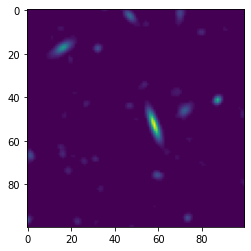

In [265]:
print_img(config.TRAIN_PATCHES_FOLDER, patch_id[0], config.VAL_PATCHES_FOLDER)

In [266]:
anch = pd.read_pickle(f'{config.VAL_PATCHES_FOLDER}/{patch_id[0]}/{patch_id[0]}.pkl')

In [267]:
anch['width'] = anch['x2s'] - anch['x1s']
anch['heght'] = anch['y2s'] - anch['y1s']

In [268]:
anch.describe() 

,x1s,y1s,x2s,y2s,class,prob,width,heght
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
from sklearn.metrics import average_precision_score

def get_map(y_pred, gt_patch_id, data_folder):
	T = {}
	P = {}
	f = config.patch_dim / float(config.resizeFinalDim)

	gt = pd.read_pickle(f'{data_folder}/{gt_patch_id}/{gt_patch_id}.pkl')

	gt['bbox_matched'] = False
	pred_probs = np.array(y_pred['prob'])
	
	box_idx_sorted_by_prob = np.argsort(pred_probs)[::-1]

	for box_idx in box_idx_sorted_by_prob:
		pred_box = y_pred.iloc[box_idx,:]
		pred_class = pred_box['class']
		pred_x1 = pred_box['x1s']
		pred_x2 = pred_box['x2s']
		pred_y1 = pred_box['y1s']
		pred_y2 = pred_box['y2s']
		pred_prob = pred_box['prob']
		if pred_class not in P:
			P[pred_class] = []
			T[pred_class] = []
		P[pred_class].append(pred_prob)
		found_match = False

		for idx, gt_box in gt.iterrows():
			gt_class = gt_box['class_label']
			gt_x1 = gt_box['x1s']/f
			gt_x2 = gt_box['x2s']/f
			gt_y1 = gt_box['y1s']/f
			gt_y2 = gt_box['y2s']/f
			gt_seen = gt_box['bbox_matched']
			if gt_class != pred_class:
				continue
			if gt_seen:
				continue
			iou = prep.iou((pred_x1, pred_y1, pred_x2, pred_y2), (gt_x1, gt_y1, gt_x2, gt_y2))
			if iou >= 0.5:
				found_match = True
				gt_box['bbox_matched'] = True
				break
			else:
				continue

		T[pred_class].append(int(found_match))
		print('T',T)
	# display(gt.head())

	for idx, gt_box in gt.iterrows():
		if not gt_box['bbox_matched']:
			if gt_box['class_label'] not in P:
				P[gt_box['class_label']] = []
				T[gt_box['class_label']] = []

			T[gt_box['class_label']].append(1)
			P[gt_box['class_label']].append(0)

	return T, P

T = {}
P = {}
t, p = get_map(boxes_coords, patch_id[0], config.TRAIN_PATCHES_FOLDER)
for key in t.keys():
	if key not in T:
		T[key] = []
		P[key] = []
	T[key].extend(t[key])
	P[key].extend(p[key])
all_aps = []
for key in T.keys():
	ap = average_precision_score(T[key], P[key])
	print('{} AP: {}'.format(key, ap))
	all_aps.append(ap)
print('mAP = {}'.format(np.mean(np.array(all_aps))))


In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

y_true = np.array([1., 1., 0, 1.])
y_scores = np.array([1,1,1,1])
print(average_precision_score(y_true, y_scores))
# print(precision_score(y_true, y_scores))
# print(recall_score(y_true, y_scores))

TODO - 20210508:
- [X] troncamento rumore a 1e-6 tramite half gaussian

TODO - 20210605:
- [X] modificare RPNNet in modo che dia in output anche la backbone - Lorenzo
- [X] scrivere bene training loop: salvare le loss in un df su disco + salvare pesi modello ad ogni giro (Lorenzo - finire di debuggare)

TODO - 20210620:
- [ ] implementare mAP in una funzione che prende come parametro un modello o i suoi pesi
- [ ] plot mAP e magari plot precision vs recall
- [ ] implementare resNet50
- [X] implementare plot predicted rois - Lorenzo
- [X] implementare plot loss training - Lorenzo
- [X] finire classe datasetv2 - Alice
- [X] check se su colab le performance sono migliori - Lorenzo

TODO - 20210627
- [X] split dataset su combinazioni classi - Alice
- [ ] provare campionamento random patch ed osservare le due distribuzioni - Alice
- [ ] Spostare validation patch nella loro folder - Alice

TODO - 20210703
- [x] sistemare salvataggio loss training loop - Lorenzo
- [ ] Riscalare immagini tra 0-255 - Alice
- [ ] capire se passare tre immagini diverse come input
- [ ] usare media vgg16 per zero-centering - Alice

TODO - 20210705
- [ ] sistemare nomi funzioni dataset per trasformazione rgb

TODO - 20210711
- [ ] rifattorizzare classe dataset spostanto nel costruttore i metodi che calcolano i suoi attributi

# Plotting

In [253]:
loss_history = np.load(f"./model/{backbone}/loss_history.npy")
print(loss_history.shape)

(32, 5)


In [245]:
loss_history

array([[2.21167493e+00, 5.48505938e+01, 1.41033335e+01, 9.02264648e+02,
        1.25000000e-01],
       [3.47529209e+00, 6.21291500e+00, 1.20885715e+01, 2.05328012e+00,
        2.50000000e-01],
       [3.08124007e+00, 4.84355471e+00, 8.05904770e+00, 2.38956679e+01,
        5.00000000e-01],
       [2.60109515e+00, 1.80010146e+00, 6.68381833e+00, 1.44240359e+01,
        4.75000000e-01],
       [3.40300663e+00, 1.71771869e+00, 8.33843269e+00, 1.56928931e+01,
        4.50000000e-01],
       [3.16217673e+00, 5.52144847e-01, 8.05904770e+00, 3.37423466e+01,
        5.00000000e-01],
       [3.15954884e+00, 2.11416296e-01, 2.44386007e+00, 1.61016402e+00,
        5.25000000e-01],
       [4.03812165e+00, 1.64660653e-01, 7.46127805e-01, 4.78080065e-01,
        5.50000000e-01],
       [3.41979742e+00, 1.61025919e-01, 9.01550260e-01, 6.71743631e-01,
        4.50000000e-01],
       [2.56015201e+00, 1.47500894e-01, 7.04970554e-01, 4.51246776e-01,
        6.00000000e-01],
       [2.21090159e+00, 1.3848

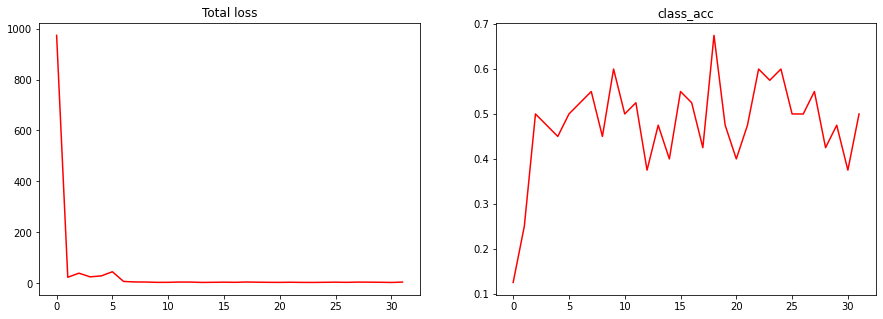

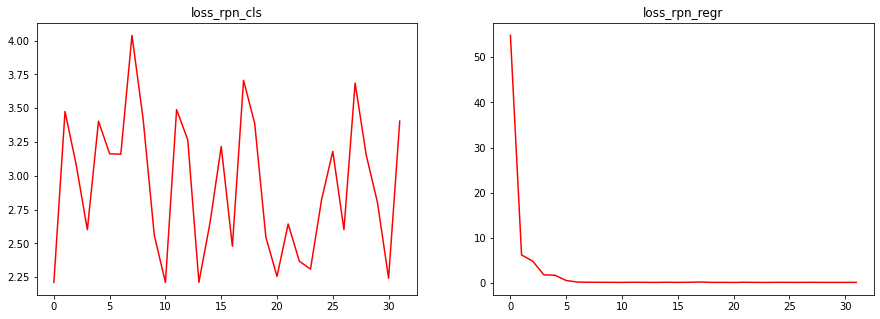

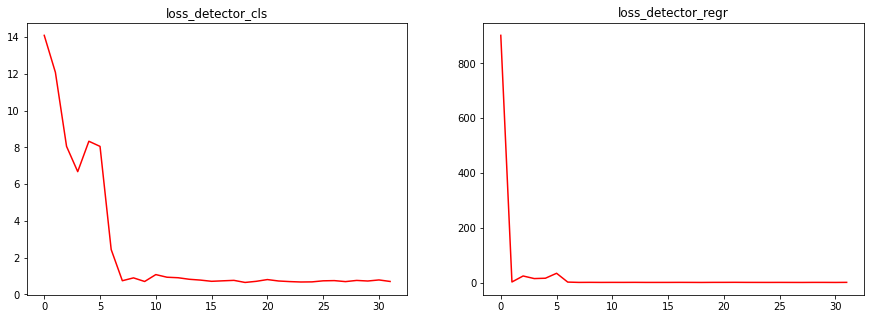

In [256]:
plot_loss(loss_history)

In [ ]:
#TODO: Provare YOLO -> forse meglio le efficientNet
# Ablation study
# Provare, a parità di frequenza, le esposizioni diverse come canali

In [1]:
# from tensorflow.keras.applications import EfficientNetB0
# model = EfficientNetB0(weights='imagenet')